In [1]:
import time
import os
import h5py
import math
from pprint import pprint

import scipy.io 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
rawdata = scipy.io.loadmat("TrainData")
print(type(rawdata))
print(list(rawdata.keys()))
particle = np.array(rawdata['TrainData'])
print(particle.shape)
pprint(particle[:,0])

<class 'dict'>
['__header__', '__version__', '__globals__', 'TrainData']
(9, 2000)
array([1.66000000e+02, 1.41000000e+02, 3.50000000e+01, 5.59348234e-01,
       1.22520000e+04, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00])


# TrainData

1. x
2. y
3. z
4. Intensity
5. order
6. original type
7. training type
8. training binary type
9. training binary type

# TestData

1. x
2. y
3. z
4. Intensity
5. order
6. original type
7. note

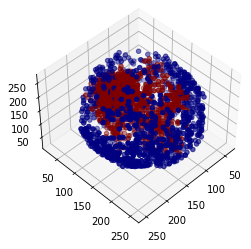

In [3]:
from mpl_toolkits.mplot3d import Axes3D
fig1 = plt.figure()
ax = plt.axes(projection='3d')

x = particle[0,:]
y = particle[1,:]
z = particle[2,:]
c = particle[6,:]
ax.scatter(x, y, z, c = c, cmap = plt.get_cmap('jet'))
ax.view_init(45, 45)

In [4]:
##-----------------------------------------------------------------------------
## Load Training data
##-----------------------------------------------------------------------------
# We use h5py as an alternate to scipy.io, because matlab v7.3 files use HDF format.
# Remember h5py.File acts like a Python dictionary.
AtomIntensity = h5py.File('dAtomIntensity_TrainData_New.mat', 'r')
print(type(AtomIntensity))
print(list(AtomIntensity.keys()))
Intensity = np.array(AtomIntensity.get('dAtomIntensity_TrainData_New'))
print(Intensity.shape)

<class 'h5py._hl.files.File'>
['dAtomIntensity_TrainData_New']
(2000, 7, 7, 7)


In [5]:
AtomType = scipy.io.loadmat('iAtomType_New')
print(type(AtomType))
print(list(AtomType.keys()))
Types = np.array(AtomType['iAtomType_New'])
print(Types.shape)
print(Types[0,:])

<class 'dict'>
['__header__', '__version__', '__globals__', 'iAtomType_New']
(2000, 1)
[1]


In [6]:
##-----------------------------------------------------------------------------
## Training set & Testing set
##-----------------------------------------------------------------------------
# rearrange the order of Intensity & Type
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html
r = np.random.permutation(len(Intensity))
print(r)
x_train = Intensity[r]
x_label = Types[r] -1    # 改成0和1
print("x_train.shape={}, x_label.shape={}".format(x_train.shape, x_label.shape))

for i in range(3):
    print("Before permutation")
    print(r[i], Intensity[r[i],:,1,1])
    print("After permutation")
    print(i, x_train[i,:,1,1])

[1488 1424  318 ... 1651  925 1666]
x_train.shape=(2000, 7, 7, 7), x_label.shape=(2000, 1)
Before permutation
1488 [0.22270968 0.54956769 0.75975122 0.95674769 1.00099968 0.82408744
 0.47900855]
After permutation
0 [0.22270968 0.54956769 0.75975122 0.95674769 1.00099968 0.82408744
 0.47900855]
Before permutation
1424 [0.45720104 0.38829559 0.47783068 0.6098865  0.40561782 0.12355859
 0.01708697]
After permutation
1 [0.45720104 0.38829559 0.47783068 0.6098865  0.40561782 0.12355859
 0.01708697]
Before permutation
318 [0.24678224 0.19872897 0.37208597 0.51036591 0.42941525 0.2250561
 0.19180911]
After permutation
2 [0.24678224 0.19872897 0.37208597 0.51036591 0.42941525 0.2250561
 0.19180911]


In [7]:
# Extend one more dim for channel
x_train = x_train.reshape(-1, x_train.shape[1], x_train.shape[2], x_train.shape[3], 1)
#x_train = x_train.reshape(x_train.shape[0], 7, 7, 7, 1)

# Change label from single value to one-hot vector.
x_label_R = np_utils.to_categorical(x_label, num_classes=2)

print("x_train.shape={}, x_label.shape={}".format(x_train.shape, x_label_R.shape))

x_train.shape=(2000, 7, 7, 7, 1), x_label.shape=(2000, 2)


In [8]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv3D, MaxPooling3D, LeakyReLU

# https://keras.io/layers/advanced-activations/#leakyrelu
model = Sequential()
model.add(Conv3D(
    filters=32,
    kernel_size=(3,3,3),
    padding='same',
    batch_input_shape=(None,x_train.shape[1], x_train.shape[2], x_train.shape[3],1),
    activation='linear'
))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(filters=64, kernel_size=(3,3,3), padding='same', activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(2048, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

model.add(Dense(256, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

model.add(Dense(64, activation='linear'))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 7, 7, 7, 32)       896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 7, 32)       0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 3, 3, 3, 32)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 3, 3, 3, 64)       55360     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 3, 3, 3, 64)       0         
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 1, 1, 64)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 1, 1, 64)      

In [10]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 

# Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.
# verbose=2 is recommended when not running interactively
train_history=model.fit(x = x_train, y = x_label_R, validation_split=0.1, epochs=10, batch_size=100, verbose=2)

model.save('my_CNNmodel.h5')  


Train on 1800 samples, validate on 200 samples
Epoch 1/10
 - 1s - loss: 0.4987 - accuracy: 0.6944 - val_loss: 0.1207 - val_accuracy: 1.0000
Epoch 2/10
 - 0s - loss: 0.0391 - accuracy: 0.9978 - val_loss: 1.0085e-06 - val_accuracy: 1.0000
Epoch 3/10
 - 0s - loss: 0.0109 - accuracy: 0.9972 - val_loss: 2.5366e-05 - val_accuracy: 1.0000
Epoch 4/10
 - 0s - loss: 0.0133 - accuracy: 0.9972 - val_loss: 1.1464e-04 - val_accuracy: 1.0000
Epoch 5/10
 - 0s - loss: 5.3923e-04 - accuracy: 1.0000 - val_loss: 1.8374e-05 - val_accuracy: 1.0000
Epoch 6/10
 - 0s - loss: 1.9532e-04 - accuracy: 1.0000 - val_loss: 7.2238e-06 - val_accuracy: 1.0000
Epoch 7/10
 - 0s - loss: 1.3046e-04 - accuracy: 1.0000 - val_loss: 4.2169e-06 - val_accuracy: 1.0000
Epoch 8/10
 - 0s - loss: 9.2013e-05 - accuracy: 1.0000 - val_loss: 2.7245e-06 - val_accuracy: 1.0000
Epoch 9/10
 - 0s - loss: 1.2124e-04 - accuracy: 1.0000 - val_loss: 1.9258e-06 - val_accuracy: 1.0000
Epoch 10/10
 - 0s - loss: 7.2590e-05 - accuracy: 1.0000 - val_l

In [11]:
# https://keras.io/zh/visualization/
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train history')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    legendLoc = 'lower right' if(train=='accuracy') else 'upper right'

    plt.legend(['train', 'validation'], loc=legendLoc)

    plt.show()

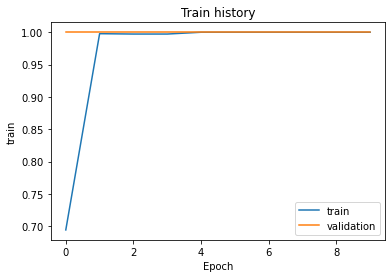

In [12]:
 show_train_history(train_history, 'accuracy', 'val_accuracy')

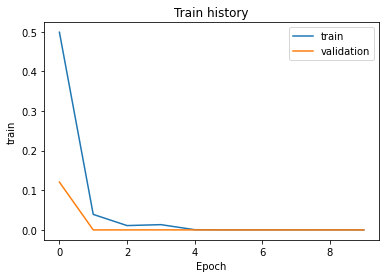

In [13]:
show_train_history(train_history, 'loss', 'val_loss')